In [3]:
# Import pandas
import pandas as pd
# Import yfinance
#import yfinance as yf
# Import data from yahoo finance
data = pd.read_excel("D:\Stock Market\Daily\Test\EGX30C.xlsx")
# Drop the NaN values
data = data.dropna()
data.head(-5)

,TICKER,PER,Date,Time,Open,High,Low,Close,Volume
0,EGX30,D,01/01/1998,00:00:00,1000.00,1000.25,1000.00,1000.25,0
1,EGX30,D,01/04/1998,00:00:00,1000.25,1000.25,998.39,998.39,0
2,EGX30,D,01/05/1998,00:00:00,998.39,998.39,996.25,996.25,0
3,EGX30,D,01/06/1998,00:00:00,996.25,996.25,992.87,992.87,0
4,EGX30,D,01/07/1998,00:00:00,992.87,992.87,989.35,989.35,0
...,...,...,...,...,...,...,...,...,...
5417,EGX30,D,03/24/2020,00:00:00,10047.44,10047.65,9770.23,9770.48,194538448
5418,EGX30,D,03/25/2020,00:00:00,9770.48,9910.81,9770.48,9865.67,148627616
5419,EGX30,D,03/26/2020,00:00:00,9865.67,9930.28,9856.90,9912.98,154830368
5420,EGX30,D,03/29/2020,00:00:00,9912.98,9913.16,9744.74,9760.18,145732704


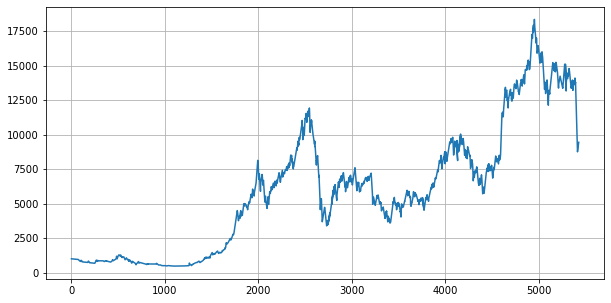

In [4]:
# Import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fast')
# Plot the closing price
data.Close.plot(figsize=(10,5))
plt.grid()
plt.show()

In [5]:
# Import talib
import talib
# Calculate parabolic sar
data['SAR'] = talib.SAR(data.High, data.Low, acceleration=0.02, maximum=0.2)

In [13]:
data['SAR'].round(2).head(-5)

0           NaN
1        998.39
2       1000.25
3       1000.25
4        999.95
         ...   
5417    8159.84
5418    8204.93
5419    8249.13
5420    8292.44
5421    8334.88
Name: SAR, Length: 5422, dtype: float64

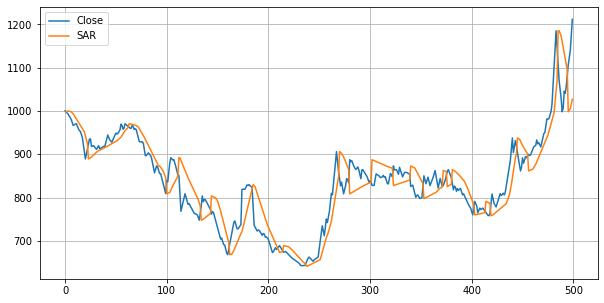

In [14]:
# Plot Parabolic SAR with close price
data[['Close', 'SAR']][:500].plot(figsize=(10,5))
plt.grid()
plt.show()

## Ichimoku Cloud

In [15]:
# Calculate Tenkan-sen
high_9 = data.High.rolling(9).max()
low_9 = data.Low.rolling(9).min()
data['tenkan_sen_line'] = (high_9 + low_9) /2
# Calculate Kijun-sen
high_26 = data.High.rolling(26).max()
low_26 = data.Low.rolling(26).min()
data['kijun_sen_line'] = (high_26 + low_26) / 2
# Calculate Senkou Span A
data['senkou_spna_A'] = ((data.tenkan_sen_line + data.kijun_sen_line) / 2).shift(26)
# Calculate Senkou Span B
high_52 = data.High.rolling(52).max()
low_52 = data.High.rolling(52).min()
data['senkou_spna_B'] = ((high_52 + low_52) / 2).shift(26)
# Calculate Chikou Span B
data['chikou_span'] = data.Close.shift(-26)

In [16]:
data.head()

,TICKER,PER,Date,Time,Open,High,Low,Close,Volume,SAR,tenkan_sen_line,kijun_sen_line,senkou_spna_A,senkou_spna_B,chikou_span
0,EGX30,D,01/01/1998,00:00:00,1000.00,1000.25,1000.00,1000.25,0,NaN,NaN,NaN,NaN,NaN,917.93
1,EGX30,D,01/04/1998,00:00:00,1000.25,1000.25,998.39,998.39,0,998.3900,NaN,NaN,NaN,NaN,918.68
2,EGX30,D,01/05/1998,00:00:00,998.39,998.39,996.25,996.25,0,1000.2500,NaN,NaN,NaN,NaN,920.00
3,EGX30,D,01/06/1998,00:00:00,996.25,996.25,992.87,992.87,0,1000.2500,NaN,NaN,NaN,NaN,914.02
4,EGX30,D,01/07/1998,00:00:00,992.87,992.87,989.35,989.35,0,999.9548,NaN,NaN,NaN,NaN,913.93


## Plot komu Cloud

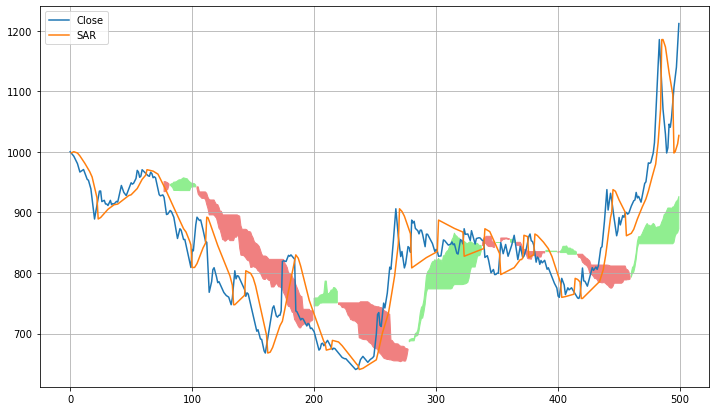

In [17]:
# Plot closing price and parabolic SAR
komu_cloud = data[['Close','SAR']][:500].plot(figsize=(12, 7))
# Plot Komu cloud
komu_cloud.fill_between(data.index[:500], data.senkou_spna_A[:500], data.senkou_spna_B[:500],
 where=data.senkou_spna_A[:500] >= data.senkou_spna_B[:500], color='lightgreen')
komu_cloud.fill_between(data.index[:500], data.senkou_spna_A[:500], data.senkou_spna_B[:500],
 where=data.senkou_spna_A[:500] < data.senkou_spna_B[:500], color='lightcoral')
plt.grid()
plt.legend()
plt.show()

## Buy Signal

In [18]:
data['signal'] = 0
data.loc[(data.Close > data.senkou_spna_A) & (data.Close >
 data.senkou_spna_B) & (data.Close > data.SAR), 'signal'] = 1

## Sell Signal

In [19]:
data.loc[(data.Close < data.senkou_spna_A) & (data.Close <
 data.senkou_spna_B) & (data.Close < data.SAR), 'signal'] = -1

In [20]:
data['signal'].value_counts()

 0    2434
 1    1837
-1    1156
Name: signal, dtype: int64

## Calculate Strategy Returns

In [22]:
# Calculate daily returns
daily_returns = data.Close.pct_change()
# Calculate strategy returns
strategy_returns = daily_returns *data['signal'].shift(1

SyntaxError: unexpected EOF while parsing (<ipython-input-22-84a1c4cdb63e>, line 4)

In [23]:
# Calculate cumulative returns
(strategy_returns+1).cumprod().plot(figsize=(10,5))
# Plot the strategy returns
plt.xlabel('Date')
plt.ylabel('Strategy Returns (%)')
plt.grid()
plt.show()

NameError: name 'strategy_returns' is not defined

In [6]:
import pandas_datareader.data as web
import datetime
import talib as ta

start = datetime.datetime.strptime('12/1/2015', '%m/%d/%Y')
end = datetime.datetime.strptime('2/20/2016', '%m/%d/%Y')
f =pd.read_excel("D:\Stock Market\Daily\Test\EGX30D.xlsx")
print('Closing Prices')
print(f['Close'].describe())
print(f.Close)
print(ta.RSI(f.Close, 2))
print(ta.SMA(f.Close, 2))
print(ta.SMA(f.Volume, 4))
print(ta.ATR)
print(ta.ATR(f.High, f.Low, f.Close, 3))

C:\Users\osama\AppData\Roaming\Python\Python38\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Closing Prices
count     5427.000000
mean      5956.902663
std       4543.177965
min        445.530000
25%       1065.175000
50%       5689.230000
75%       8344.520000
max      18363.290000
Name: Close, dtype: float64
0       1000.25
1        998.39
2        996.25
3        992.87
4        989.35
         ...   
5422    9593.94
5423    9424.89
5424    9455.38
5425    9272.88
5426    9446.99
Name: Close, Length: 5427, dtype: float64
0             NaN
1             NaN
2        0.000000
3        0.000000
4        0.000000
          ...    
5422    36.135640
5423    15.810492
5424    30.010895
5425     9.940034
5426    60.431985
Length: 5427, dtype: float64
0            NaN
1        999.320
2        997.320
3        994.560
4        991.110
          ...   
5422    9557.685
5423    9509.415
5424    9440.135
5425    9364.130
5426    9359.935
Length: 5427, dtype: float64
0               NaN
1               NaN
2               NaN
3               0.0
4               0.0
           ...     


In [4]:
# talib SAR Indicator

import talib

def initialize(context):
    schedule_function(record_SAR, date_rules.every_day(), time_rules.market_close(hours = 1)) 
    
def record_SAR(context, data):   

    stk = symbol('QQQ')
    
    H = data.history(stk,'high', 2, '1d').dropna()
    L = data.history(stk,'low', 2, '1d').dropna()   
    CP = data.current(stk,'price')
    
    ta_SAR = talib.SAR(H, L, 0.02, 0.2)    
    SAR = ta_SAR[-1]
    record( SAR = SAR, Price = CP)

In [ ]:
# -*- coding: utf-8 -*-

from __future__ import division
from functools import wraps
import numpy as np
from pandas import DataFrame, Series
from pandas.stats import moments


def sar(s, af=0.02, amax=0.2):
    high, low = s.high, s.low

    # Starting values
    sig0, xpt0, af0 = True, high[0], af
    sar = [low[0] - (high - low).std()]

    for i in xrange(1, len(s)):
        sig1, xpt1, af1 = sig0, xpt0, af0

        lmin = min(low[i - 1], low[i])
        lmax = max(high[i - 1], high[i])

        if sig1:
            sig0 = low[i] > sar[-1]
            xpt0 = max(lmax, xpt1)
        else:
            sig0 = high[i] >= sar[-1]
            xpt0 = min(lmin, xpt1)

        if sig0 == sig1:
            sari = sar[-1] + (xpt1 - sar[-1]) * af1
            af0 = min(amax, af1 + af)

            if sig0:
                af0 = af0 if xpt0 > xpt1 else af1
                sari = min(sari, lmin)
            else:
                af0 = af0 if xpt0 < xpt1 else af1
                sari = max(sari, lmax)
        else:
            af0 = af
            sari = xpt0

        sar.append(sari)

    return Series(sar, index=s.index)

In [ ]:
# -*- coding: utf-8 -*-

from __future__ import division

from functools import wraps

import numpy as np
from pandas import DataFrame, Series
from pandas.stats import moments


def series_indicator(col):
    def inner_series_indicator(f):
        @wraps(f)
        def wrapper(s, *args, **kwargs):
            if isinstance(s, DataFrame):
                s = s[col]
            return f(s, *args, **kwargs)
        return wrapper
    return inner_series_indicator


def _wilder_sum(s, n):
    s = s.dropna()

    nf = (n - 1) / n
    ws = [np.nan]*(n - 1) + [s[n - 1] + nf*sum(s[:n - 1])]

    for v in s[n:]:
        ws.append(v + ws[-1]*nf)

    return Series(ws, index=s.index)


@series_indicator('high')
def hhv(s, n):
    return moments.rolling_max(s, n)


@series_indicator('low')
def llv(s, n):
    return moments.rolling_min(s, n)


@series_indicator('close')
def ema(s, n, wilder=False):
    span = n if not wilder else 2*n - 1
    return moments.ewma(s, span=span)


@series_indicator('close')
def macd(s, nfast=12, nslow=26, nsig=9, percent=True):
    fast, slow = ema(s, nfast), ema(s, nslow)

    if percent:
        macd = 100*(fast / slow - 1)
    else:
        macd = fast - slow

    sig = ema(macd, nsig)
    hist = macd - sig

    return DataFrame(dict(macd=macd, signal=sig, hist=hist,
                          fast=fast, slow=slow))


def aroon(s, n=25):
    up = 100 * moments.rolling_apply(s.high, n + 1, lambda x: x.argmax()) / n
    dn = 100 * moments.rolling_apply(s.low, n + 1, lambda x: x.argmin()) / n

    return DataFrame(dict(up=up, down=dn))


@series_indicator('close')
def rsi(s, n=14):
    diff = s.diff()
    which_dn = diff < 0

    up, dn = diff, diff*0
    up[which_dn], dn[which_dn] = 0, -up[which_dn]

    emaup = ema(up, n, wilder=True)
    emadn = ema(dn, n, wilder=True)

    return 100 * emaup/(emaup + emadn)


def stoch(s, nfastk=14, nfullk=3, nfulld=3):
    if not isinstance(s, DataFrame):
        s = DataFrame(dict(high=s, low=s, close=s))

    hmax, lmin = hhv(s, nfastk), llv(s, nfastk)

    fastk = 100 * (s.close - lmin)/(hmax - lmin)
    fullk = moments.rolling_mean(fastk, nfullk)
    fulld = moments.rolling_mean(fullk, nfulld)

    return DataFrame(dict(fastk=fastk, fullk=fullk, fulld=fulld))


@series_indicator('close')
def dtosc(s, nrsi=13, nfastk=8, nfullk=5, nfulld=3):
    srsi = stoch(rsi(s, nrsi), nfastk, nfullk, nfulld)
    return DataFrame(dict(fast=srsi.fullk, slow=srsi.fulld))


def atr(s, n=14):
    cs = s.close.shift(1)
    tr = s.high.combine(cs, max) - s.low.combine(cs, min)

    return ema(tr, n, wilder=True)


def cci(s, n=20, c=0.015):
    if isinstance(s, DataFrame):
        s = s[['high', 'low', 'close']].mean(axis=1)

    mavg = moments.rolling_mean(s, n)
    mdev = moments.rolling_apply(s, n, lambda x: np.fabs(x - x.mean()).mean())

    return (s - mavg)/(c * mdev)


def cmf(s, n=20):
    clv = (2*s.close - s.high - s.low) / (s.high - s.low)
    vol = s.volume

    return moments.rolling_sum(clv*vol, n) / moments.rolling_sum(vol, n)


def force(s, n=2):
    return ema(s.close.diff()*s.volume, n)


@series_indicator('close')
def kst(s, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9):
    rocma1 = moments.rolling_mean(s / s.shift(r1) - 1, n1)
    rocma2 = moments.rolling_mean(s / s.shift(r2) - 1, n2)
    rocma3 = moments.rolling_mean(s / s.shift(r3) - 1, n3)
    rocma4 = moments.rolling_mean(s / s.shift(r4) - 1, n4)

    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = moments.rolling_mean(kst, nsig)

    return DataFrame(dict(kst=kst, signal=sig))


def ichimoku(s, n1=9, n2=26, n3=52):
    conv = (hhv(s, n1) + llv(s, n1)) / 2
    base = (hhv(s, n2) + llv(s, n2)) / 2

    spana = (conv + base) / 2
    spanb = (hhv(s, n3) + llv(s, n3)) / 2

    return DataFrame(dict(conv=conv, base=base, spana=spana.shift(n2),
                          spanb=spanb.shift(n2), lspan=s.close.shift(-n2)))


def ultimate(s, n1=7, n2=14, n3=28):
    cs = s.close.shift(1)
    bp = s.close - s.low.combine(cs, min)
    tr = s.high.combine(cs, max) - s.low.combine(cs, min)

    avg1 = moments.rolling_sum(bp, n1) / moments.rolling_sum(tr, n1)
    avg2 = moments.rolling_sum(bp, n2) / moments.rolling_sum(tr, n2)
    avg3 = moments.rolling_sum(bp, n3) / moments.rolling_sum(tr, n3)

    return 100*(4*avg1 + 2*avg2 + avg3) / 7


def auto_envelope(s, nema=22, nsmooth=100, ndev=2.7):
    sema = ema(s.close, nema)
    mdiff = s[['high','low']].sub(sema, axis=0).abs().max(axis=1)
    csize = moments.ewmstd(mdiff, nsmooth)*ndev

    return DataFrame(dict(ema=sema, lenv=sema - csize, henv=sema + csize))


@series_indicator('close')
def bbands(s, n=20, ndev=2):
    mavg = moments.rolling_mean(s, n)
    mstd = moments.rolling_std(s, n)

    hband = mavg + ndev*mstd
    lband = mavg - ndev*mstd

    return DataFrame(dict(ma=mavg, lband=lband, hband=hband))


def safezone(s, position, nmean=10, npen=2.0, nagg=3):
    if isinstance(s, DataFrame):
        s = s.low if position == 'long' else s.high

    sgn = -1.0 if position == 'long' else 1.0

    # Compute the average upside/downside penetration
    pen = moments.rolling_apply(
        sgn*s.diff(), nmean,
        lambda x: x[x > 0].mean() if (x > 0).any() else 0
    )

    stop = s + sgn*npen*pen
    return hhv(stop, nagg) if position == 'long' else llv(stop, nagg)


def sar(s, af=0.02, amax=0.2):
    high, low = s.high, s.low

    # Starting values
    sig0, xpt0, af0 = True, high[0], af
    sar = [low[0] - (high - low).std()]

    for i in xrange(1, len(s)):
        sig1, xpt1, af1 = sig0, xpt0, af0

        lmin = min(low[i - 1], low[i])
        lmax = max(high[i - 1], high[i])

        if sig1:
            sig0 = low[i] > sar[-1]
            xpt0 = max(lmax, xpt1)
        else:
            sig0 = high[i] >= sar[-1]
            xpt0 = min(lmin, xpt1)

        if sig0 == sig1:
            sari = sar[-1] + (xpt1 - sar[-1])*af1
            af0 = min(amax, af1 + af)

            if sig0:
                af0 = af0 if xpt0 > xpt1 else af1
                sari = min(sari, lmin)
            else:
                af0 = af0 if xpt0 < xpt1 else af1
                sari = max(sari, lmax)
        else:
            af0 = af
            sari = xpt0

        sar.append(sari)

    return Series(sar, index=s.index)


def adx(s, n=14):
    cs = s.close.shift(1)
    tr = s.high.combine(cs, max) - s.low.combine(cs, min)
    trs = _wilder_sum(tr, n)

    up = s.high - s.high.shift(1)
    dn = s.low.shift(1) - s.low

    pos = ((up > dn) & (up > 0)) * up
    neg = ((dn > up) & (dn > 0)) * dn

    dip = 100 * _wilder_sum(pos, n) / trs
    din = 100 * _wilder_sum(neg, n) / trs

    dx = 100 * np.abs((dip - din)/(dip + din))
    adx = ema(dx, n, wilder=True)

    return DataFrame(dict(adx=adx, dip=dip, din=din))


def chandelier(s, position, n=22, npen=3):
    if position == 'long':
        return hhv(s, n) - npen*atr(s, n)
    else:
        return llv(s, n) + npen*atr(s, n)


def vortex(s, n=14):
    ss = s.shift(1)

    tr = s.high.combine(ss.close, max) - s.low.combine(ss.close, min)
    trn = moments.rolling_sum(tr, n)

    vmp = np.abs(s.high - ss.low)
    vmm = np.abs(s.low - ss.high)

    vip = moments.rolling_sum(vmp, n) / trn
    vin = moments.rolling_sum(vmm, n) / trn

    return DataFrame(dict(vin=vin, vip=vip))


@series_indicator('close')
def gmma(s, nshort=[3, 5, 8, 10, 12, 15],
         nlong=[30, 35, 40, 45, 50, 60]):
    short = {str(n): ema(s, n) for n in nshort}
    long = {str(n): ema(s, n) for n in nlong}

    return DataFrame(short), DataFrame(long)


def zigzag(s, pct=5):
    ut = 1 + pct / 100
    dt = 1 - pct / 100

    ld = s.index[0]
    lp = s.close[ld]
    tr = None

    zzd, zzp = [ld], [lp]

    for ix, ch, cl in zip(s.index, s.high, s.low):
        # No initial trend
        if tr is None:
            if ch / lp > ut:
                tr = 1
            elif cl / lp < dt:
                tr = -1
        # Trend is up
        elif tr == 1:
            # New high
            if ch > lp:
                ld, lp = ix, ch
            # Reversal
            elif cl / lp < dt:
                zzd.append(ld)
                zzp.append(lp)

                tr, ld, lp = -1, ix, cl
        # Trend is down
        else:
            # New low
            if cl < lp:
                ld, lp = ix, cl
            # Reversal
            elif ch / lp > ut:
                zzd.append(ld)
                zzp.append(lp)

                tr, ld, lp = 1, ix, ch

    # Extrapolate the current trend
    if zzd[-1] != s.index[-1]:
        zzd.append(s.index[-1])

        if tr is None:
            zzp.append(s.close[zzd[-1]])
        elif tr == 1:
            zzp.append(s.high[zzd[-1]])
        else:
            zzp.append(s.low[zzd[-1]])

    return Series(zzp, index=zzd)